Title:

Introduction:
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

In [37]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [38]:
#loads data from the original source on the web 
titles_data <- read_csv("https://github.com/sm020402/dsci-100-2022w1-group-98/raw/main/project_proposal/data/titles.csv")

#filter out only movies from the data and select only the number column
titles_movie_data <- titles_data %>%
    filter(type == "MOVIE") %>%
    select(runtime, release_year, tmdb_popularity,imdb_score, imdb_votes, tmdb_popularity, tmdb_score)

titles_movie_data_scaled <- titles_movie_data|>
mutate(scaled_runtime = scale(runtime, center=TRUE),
       scaled_release_year=scale(release_year, center=TRUE),
       scaled_tmdb_popularity=scale(tmdb_popularity, center=TRUE),
       scaled_imdb_score=scale(imdb_score, center=TRUE),
       scaled_imdb_votes=scale(imdb_votes, center=TRUE),
       scaled_tmdb_popularity=scale(tmdb_popularity, center=TRUE),
       scaled_tmdb_score=scale(tmdb_score, center=TRUE))
titles_movie_scaled <- titles_movie_data_scaled|>
select(-runtime, -release_year, -tmdb_popularity,-imdb_score, -imdb_votes, -tmdb_popularity, -tmdb_score)
titles_movie_scaled   

Rows: 5850 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): id, title, type, description, age_certification, genres, production...
dbl (7): release_year, runtime, seasons, imdb_score, imdb_votes, tmdb_popula...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


scaled_runtime,scaled_release_year,scaled_tmdb_popularity,scaled_imdb_score,scaled_imdb_votes,scaled_tmdb_score
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0.5152087,-5.230902,0.26452421,1.732396,7.316441,1.6429975
0.3520267,-5.755685,-0.13199719,1.288931,0.755946,0.8008956
-0.2354283,-5.362098,-0.06217202,1.732396,4.750908,1.2904452
⋮,⋮,⋮,⋮,⋮,⋮
1.1679366,0.6729035,NA,1.288931,-0.2486140,NA
-0.2680647,0.6729035,0.07289248,-2.170092,-0.2512348,-0.1571271
-1.9977936,0.6729035,-0.24362011,NA,NA,3.3875568


In [39]:
titles_missing_values <- 
sapply(titles_movie_scaled, function(x) sum(is.na(x))) #count missing values for every column in dataset
titles_missing_values   

scaled_runtime    scaled_release_year scaled_tmdb_popularity 
                     0                      0                     62 
     scaled_imdb_score      scaled_imdb_votes      scaled_tmdb_score 
                   315                    331                    195

In [40]:
titles_movie <- na.omit(titles_movie_scaled) 

In [41]:
set.seed(1)
titles_split <- initial_split(titles_movie, prop = 0.75 , strata = scaled_tmdb_popularity)
titles_training <- training(titles_split)
titles_testing <- testing(titles_split)
titles_training
titles_testing

scaled_runtime,scaled_release_year,scaled_tmdb_popularity,scaled_imdb_score,scaled_imdb_votes,scaled_tmdb_score
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
-0.03960998,-5.755685,-0.2439788,-0.04146245,-0.2479588,-0.3487316
1.13530021,-4.837315,-0.2426722,0.84546672,-0.2357066,-0.4445339
1.00475464,-6.149272,-0.2440172,1.64370298,-0.2335444,1.9505228
⋮,⋮,⋮,⋮,⋮,⋮
-1.1166110,0.6729035,0.18199191,-1.371856,-0.2513752,1.0883024
-2.3894304,0.6729035,0.42844875,-0.573620,-0.2515156,-0.1571271
-0.2680647,0.6729035,0.07289248,-2.170092,-0.2512348,-0.1571271


scaled_runtime,scaled_release_year,scaled_tmdb_popularity,scaled_imdb_score,scaled_imdb_votes,scaled_tmdb_score
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0.5152087,-5.230902,0.26452421,1.7323959,7.31644096,1.6429975
0.6131179,-6.542859,-0.09212088,0.9341596,-0.09793702,0.6092911
0.5478451,-8.117207,-0.14602371,1.1115455,0.14581560,0.7050933
⋮,⋮,⋮,⋮,⋮,⋮
1.62484613,0.6729035,-0.2348840,-1.0170845,-0.2378594,-1.1151497
-0.20279195,0.6729035,-0.2349736,0.4906951,-0.2424458,0.9925001
0.09093559,0.6729035,-0.2378302,-1.1057775,-0.2505983,0.2260820


In [42]:
titles_mean <- titles_training %>%
    select(scaled_runtime, scaled_imdb_score, scaled_imdb_votes, scaled_tmdb_popularity, scaled_tmdb_score) %>%
    map_df(mean, na.rm = TRUE)
titles_mean

titles_max <- titles_training %>%
    select(scaled_runtime, scaled_imdb_score, scaled_imdb_votes, scaled_tmdb_popularity, scaled_tmdb_score) %>%
    map_df(max, na.rm = TRUE)

titles_min <- titles_training %>%
    select(scaled_runtime, scaled_imdb_score, scaled_imdb_votes, scaled_tmdb_popularity, scaled_tmdb_score) %>%
    map_df(min, na.rm = TRUE)

titles_range <- titles_max - titles_min
titles_range

scaled_runtime,scaled_imdb_score,scaled_imdb_votes,scaled_tmdb_popularity,scaled_tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1110287,0.02273226,0.01714836,0.01278333,-0.002239688


scaled_runtime,scaled_imdb_score,scaled_imdb_votes,scaled_tmdb_popularity,scaled_tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.277916,6.651969,21.47391,29.12192,8.622204


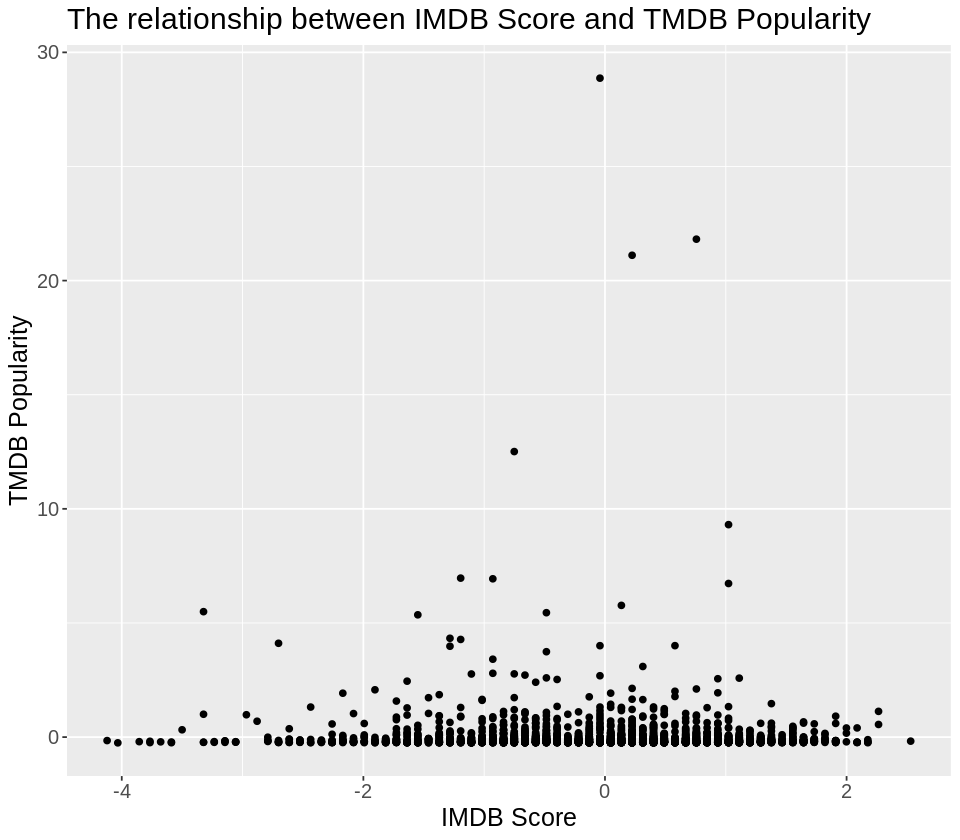

In [43]:
options(repr.plot.width = 8, repr.plot.height = 7) 
iscore_plot <- titles_training %>%
    ggplot(aes(x = scaled_imdb_score, y = scaled_tmdb_popularity)) +
    geom_point() +
    labs(x = "IMDB Score", y = "TMDB Popularity") +
    ggtitle("The relationship between IMDB Score and TMDB Popularity")+
    theme(text = element_text(size = 15))

iscore_plot

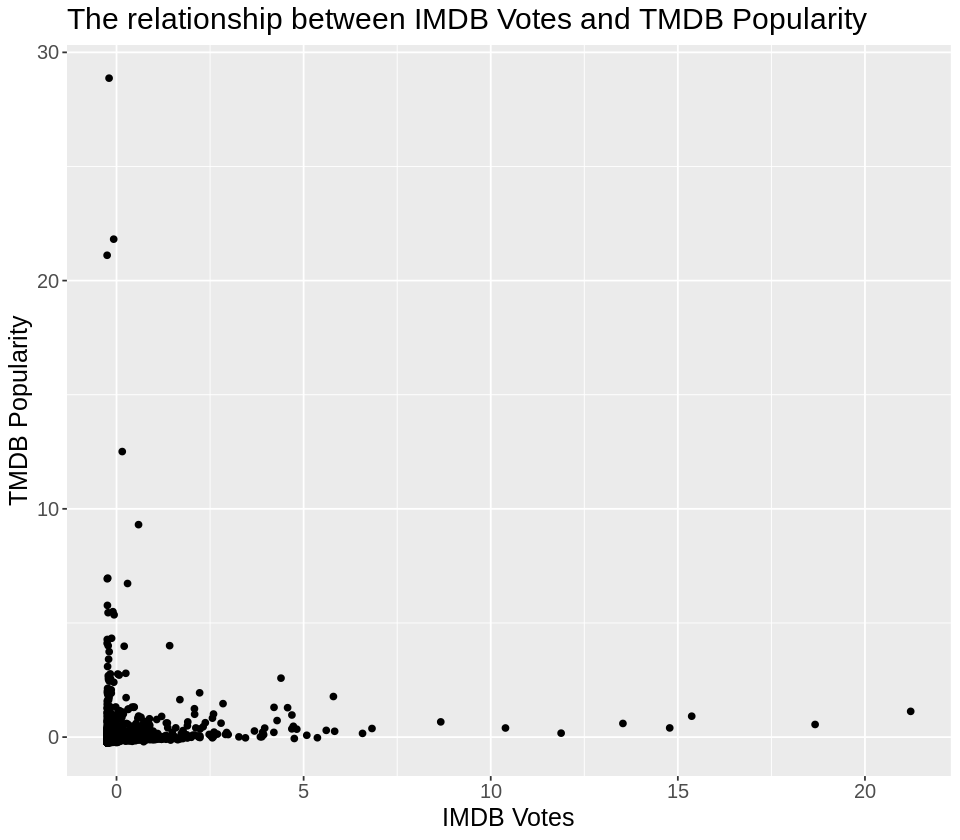

In [44]:
options(repr.plot.width = 8, repr.plot.height = 7) 
ivotes_plot <- titles_training %>%
    ggplot(aes(x = scaled_imdb_votes, y = scaled_tmdb_popularity)) +
    geom_point() +
    labs(x = "IMDB Votes", y ="TMDB Popularity") +
    ggtitle("The relationship between IMDB Votes and TMDB Popularity")+
    theme(text = element_text(size = 15))

ivotes_plot

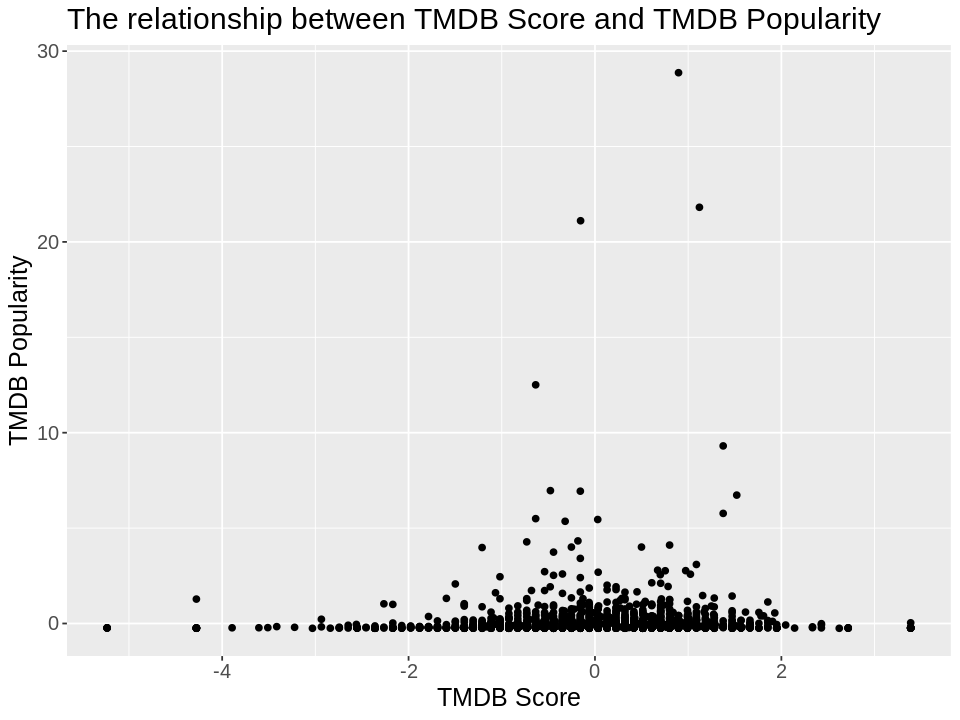

In [45]:
options(repr.plot.width = 8, repr.plot.height = 6) 
tscore_plot <- titles_training %>%
    ggplot(aes(x = scaled_tmdb_score , y = scaled_tmdb_popularity)) +
    geom_point() +
    labs(x = "TMDB Score", y ="TMDB Popularity") +
    ggtitle("The relationship between TMDB Score and TMDB Popularity")+
    theme(text = element_text(size = 15))

tscore_plot

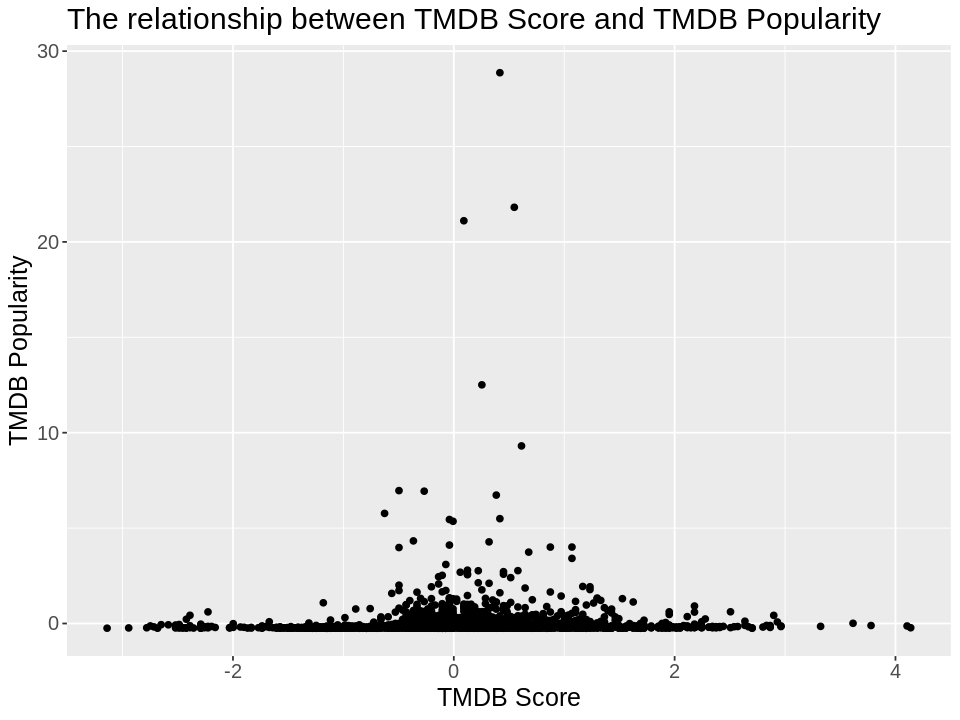

In [46]:
options(repr.plot.width = 8, repr.plot.height = 6) 
runtime_plot <- titles_training %>%
    ggplot(aes(x = scaled_runtime, y = scaled_tmdb_popularity)) +
    geom_point() +
    labs(x = "TMDB Score", y ="TMDB Popularity") +
    ggtitle("The relationship between TMDB Score and TMDB Popularity")+
    theme(text = element_text(size = 15))

runtime_plot

Methods & Results:
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 

note: all tables and figure should have a figure/table number and a legend

Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

References:
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.